# MVP Notebook — SARIMA (monthly) → Mean–Variance Optimization (Sharpe with rf)
This notebook implements an end-to-end MVP pipeline:
1) Download prices from Yahoo Finance (`yfinance`)
2) Convert to monthly returns
3) Fit SARIMA/SARIMAX *per ticker* to forecast 12 monthly returns (≈1-year horizon)
4) Build robust expected returns: `mu_final = (1-α)*mu_hist + α*mu_arima`
5) Estimate annual covariance Σ from monthly returns
6) Optimize weights with constraints (long-only, min/max weights, max volatility) maximizing Sharpe with rf

> Notes: Educational MVP, not financial advice. For production: shrinkage covariance, turnover penalties, costs, and backtesting.


In [71]:
!pip install jinja2

In [72]:
# If needed:
# !pip install yfinance statsmodels scipy pandas numpy

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.optimize import minimize

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


## 1) Parameters de entrada

In [73]:
# --- Portfolio input (define investments; weights will be computed automatically) ---
portfolio = {
    "AAPL": 1500.0,   # Apple Inc.
    "MSFT": 2000.0,   # Microsoft Corporation
    "GOOGL": 1800.0,  # Alphabet Inc.
    "AMZN": 3000.0,   # Amazon.com, Inc.
    "INTC": 3000.0,    # Intel Corporation
    "NVDA": 100.0, 
    
}

# Optional benchmark ticker (for comparison, not required)
benchmark = "SPY"  # set to None if you don't want it

# --- Derived tickers + current weights (auto) ---
tickers = list(portfolio.keys())

total_investment = float(sum(portfolio.values()))
current_weights = pd.Series({t: float(v) / total_investment for t, v in portfolio.items()}).sort_index()
# Display portfolio summary
portfolio_summary = pd.DataFrame({
    "investment": pd.Series(portfolio),
    "weight": current_weights
}).sort_values("investment", ascending=False)

# --- Dates ---
start_date = "2016-01-01"
end_date   = "2025-12-31"

# --- Forecast horizon ---
H = 12  # 12 months forecast (≈ 1 year)

# --- Blending expected returns ---
alpha = 0.4  # 0.1–0.3 recommended

# --- Risk-free & constraints ---
risk_free_rate = 0.04   # annual
max_volatility = 0.225  # annual
min_weight = 0.05
max_weight = 0.30

# --- SARIMA config (simple & stable) ---
sarima_order = (1, 0, 1)
seasonal_order = (0, 0, 1, 12)

# Notes:
# - If a ticker fails to fit, we fall back to historical mean.
# - Constraints must be feasible: len(tickers)*min_weight <= 1.


## 2) Download prices (Yahoo Finance) and build monthly returns

In [74]:
def download_prices_yf(tickers, start_date, end_date):
    data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=True,
        progress=False
    )["Close"]
    if isinstance(data, pd.Series):
        data = data.to_frame()
    return data

symbols = tickers.copy()
if benchmark is not None and benchmark not in symbols:
    symbols.append(benchmark)

prices_d = download_prices_yf(symbols, start_date, end_date)

# Basic cleaning: drop tickers with too many missing values (portfolio tickers only)
min_coverage = 0.90
coverage = 1 - prices_d[tickers].isna().mean()
keep = coverage[coverage >= min_coverage].index.tolist()
dropped = sorted(set(tickers) - set(keep))

# Keep: portfolio tickers that passed + benchmark (if available)
cols_to_keep = keep + ([benchmark] if benchmark is not None and benchmark in prices_d.columns else [])
prices_d = prices_d[cols_to_keep].dropna(how="all")

print("Kept portfolio tickers:", keep)
if dropped:
    print("Dropped (insufficient data coverage):", dropped)
if benchmark is not None:
    print("Benchmark:", benchmark if benchmark in prices_d.columns else f"{benchmark} (not available)")

# Convert to monthly end-of-month prices
prices_m = prices_d.resample("ME").last().dropna(how="all")

# Monthly returns
ret_m = prices_m.pct_change().dropna(how="all")

# Display as percentages
ret_m.tail(10).style.format("{:.2%}")

Kept portfolio tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'INTC', 'NVDA']
Benchmark: SPY


Ticker,AAPL,MSFT,GOOGL,AMZN,INTC,NVDA,SPY
Date,,,,,,,
2025-03-31 00:00:00,-8.15%,-5.44%,-9.08%,-10.37%,-4.30%,-13.23%,-5.57%
2025-04-30 00:00:00,-4.34%,5.29%,2.69%,-3.07%,-11.49%,0.50%,-0.87%
2025-05-31 00:00:00,-5.36%,16.68%,8.15%,11.16%,-2.74%,24.06%,6.28%
2025-06-30 00:00:00,2.15%,8.05%,2.74%,7.01%,14.58%,16.93%,5.14%
2025-07-31 00:00:00,1.17%,7.26%,8.89%,6.71%,-11.61%,12.58%,2.30%
2025-08-31 00:00:00,11.96%,-4.87%,10.95%,-2.18%,22.98%,-2.07%,2.05%
2025-09-30 00:00:00,9.69%,2.22%,14.28%,-4.12%,37.78%,7.13%,3.56%
2025-10-31 00:00:00,6.18%,-0.03%,15.67%,11.23%,19.20%,8.53%,2.38%
2025-11-30 00:00:00,3.24%,-4.80%,13.87%,-4.50%,1.43%,-12.59%,0.19%


In [85]:
# Agregar después de la celda 8 (final_table)

## 8.1) Verificación de datos y look-ahead bias

print("=== VERIFICACIÓN DE BACKTEST ===\n")

# 1. Período de datos
print(f"Período de datos: {prices_port_d.index[0].date()} a {prices_port_d.index[-1].date()}")
print(f"Total días: {len(prices_port_d)}")

# 2. Verificar SPY histórico real
spy_growth = prices_d[benchmark].iloc[-1] / prices_d[benchmark].iloc[0]
print(f"\nSPY: Precio inicial ${prices_d[benchmark].iloc[0]:.2f}, Precio final ${prices_d[benchmark].iloc[-1]:.2f}")
print(f"SPY: Growth real = {spy_growth:.2f}x (vs calculado: {cum_bm.iloc[-1]:.2f}x)")

# 3. Verificar si hay look-ahead bias
print(f"\n⚠️ LOOK-AHEAD BIAS DETECTADO:")
print(f"Los pesos 'Recommended' fueron optimizados usando:")
print(f"  - SARIMA forecast del futuro (mu_arima)")
print(f"  - Datos hasta {ret_m.index[-1].date()}")
print(f"Pero se aplicaron al período completo 2016-2025")
print(f"\nEsto NO es un backtest válido. Es 'hindsight trading'.")

# 4. Validar crecimiento de tickers individuales
print(f"\n=== Crecimiento individual de tickers (2016-2025) ===")
for ticker in tickers:
    if ticker in prices_port_d.columns:
        initial = prices_port_d[ticker].dropna().iloc[0]
        final = prices_port_d[ticker].dropna().iloc[-1]
        growth = final / initial
        print(f"{ticker}: ${initial:.2f} → ${final:.2f} = {growth:.2f}x ({(growth-1)*100:.1f}% ganancia)")

=== VERIFICACIÓN DE BACKTEST ===

Período de datos: 2016-01-04 a 2025-12-30
Total días: 2513

SPY: Precio inicial $170.37, Precio final $687.01
SPY: Growth real = 4.03x (vs calculado: 4.03x)

⚠️ LOOK-AHEAD BIAS DETECTADO:
Los pesos 'Recommended' fueron optimizados usando:
  - SARIMA forecast del futuro (mu_arima)
  - Datos hasta 2025-12-31
Pero se aplicaron al período completo 2016-2025

Esto NO es un backtest válido. Es 'hindsight trading'.

=== Crecimiento individual de tickers (2016-2025) ===
AAPL: $23.75 → $273.08 = 11.50x (1049.7% ganancia)
MSFT: $47.98 → $487.48 = 10.16x (915.9% ganancia)
GOOGL: $37.69 → $313.85 = 8.33x (732.8% ganancia)
AMZN: $31.85 → $232.53 = 7.30x (630.1% ganancia)
INTC: $26.86 → $37.30 = 1.39x (38.9% ganancia)
NVDA: $0.79 → $187.54 = 237.52x (23651.6% ganancia)


## 3) Fit SARIMA per ticker and forecast 12 monthly returns

In [75]:
def forecast_returns_sarima(series_m, H, order=(1,0,1), seasonal_order=(0,0,1,12), cap_monthly=0.03):
    """Forecast H monthly returns using SARIMA/SARIMAX on a single return series."""
    y = series_m.dropna()
    if len(y) < 36:
        raise ValueError("Not enough monthly data points (need ~36+).")

    model = SARIMAX(
        y,
        order=order,
        seasonal_order=seasonal_order,
        trend="c",  # allow a constant mean (for returns)
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    fc = res.forecast(steps=H)

    #cap extreme forecasts
    if cap_monthly is not None:
        fc = fc.clip(lower=-cap_monthly, upper=cap_monthly)
    
    return fc

mu_arima = {}
forecast_paths = {}

for t in [c for c in ret_m.columns if c in tickers]:
    try:
        fc = forecast_returns_sarima(ret_m[t], H, sarima_order, seasonal_order)
        forecast_paths[t] = fc
        mu_arima[t] = float(np.prod(1 + fc.values) - 1)  # 12-step monthly forecast -> 1y
    except Exception as e:
        # Fallback: historical mean monthly return compounded for H months
        m = float(ret_m[t].mean())
        mu_arima[t] = float((1 + m)**H - 1)
        forecast_paths[t] = pd.Series([m]*H, index=pd.date_range(ret_m.index[-1] + pd.offsets.MonthEnd(1), periods=H, freq="M"))
        print(f"[WARN] {t}: SARIMA failed/insufficient data → fallback to historical mean. Reason: {e}")

mu_arima = pd.Series(mu_arima).sort_index()
mu_arima.to_frame("Expected Return (1y)").style.format("{:.2%}")

,Expected Return (1y)
AAPL,29.61%
AMZN,27.17%
GOOGL,29.95%
INTC,7.14%
MSFT,29.38%
NVDA,42.58%


In [76]:

## 3.2) Diagnóstico de forecasts SARIMA

print("=== SARIMA Forecast Diagnostics ===\n")

for t in tickers:
    fc = forecast_paths.get(t, pd.Series())
    if len(fc) > 0:
        monthly_avg = fc.mean()
        monthly_std = fc.std()
        annual_compound = float(np.prod(1 + fc.values) - 1)
        
        # Historical comparison
        hist_monthly_avg = ret_m[t].mean()
        hist_monthly_std = ret_m[t].std()
        hist_annual_compound = float((1 + hist_monthly_avg)**12 - 1)
        
        print(f"{t}:")
        print(f"  Forecast monthly avg: {monthly_avg:>7.2%}  std: {monthly_std:>6.2%}")
        print(f"  Historical monthly avg: {hist_monthly_avg:>7.2%}  std: {hist_monthly_std:>6.2%}")
        print(f"  Forecast 1y (compounded): {annual_compound:>7.2%}")
        print(f"  Historical 1y (compounded): {hist_annual_compound:>7.2%}")
        print(f"  Ratio forecast/historical: {annual_compound/hist_annual_compound if hist_annual_compound != 0 else np.nan:.2f}x")
        print()

=== SARIMA Forecast Diagnostics ===

AAPL:
  Forecast monthly avg:   2.19%  std:  0.55%
  Historical monthly avg:   2.45%  std:  7.93%
  Forecast 1y (compounded):  29.61%
  Historical 1y (compounded):  33.68%
  Ratio forecast/historical: 0.88x

MSFT:
  Forecast monthly avg:   2.17%  std:  0.34%
  Historical monthly avg:   2.13%  std:  5.91%
  Forecast 1y (compounded):  29.38%
  Historical 1y (compounded):  28.81%
  Ratio forecast/historical: 1.02x

GOOGL:
  Forecast monthly avg:   2.21%  std:  0.09%
  Historical monthly avg:   2.05%  std:  7.22%
  Forecast 1y (compounded):  29.95%
  Historical 1y (compounded):  27.62%
  Ratio forecast/historical: 1.08x

AMZN:
  Forecast monthly avg:   2.02%  std:  0.25%
  Historical monthly avg:   2.11%  std:  8.56%
  Forecast 1y (compounded):  27.17%
  Historical 1y (compounded):  28.49%
  Ratio forecast/historical: 0.95x

INTC:
  Forecast monthly avg:   0.58%  std:  0.50%
  Historical monthly avg:   0.88%  std: 10.29%
  Forecast 1y (compounded):   7.

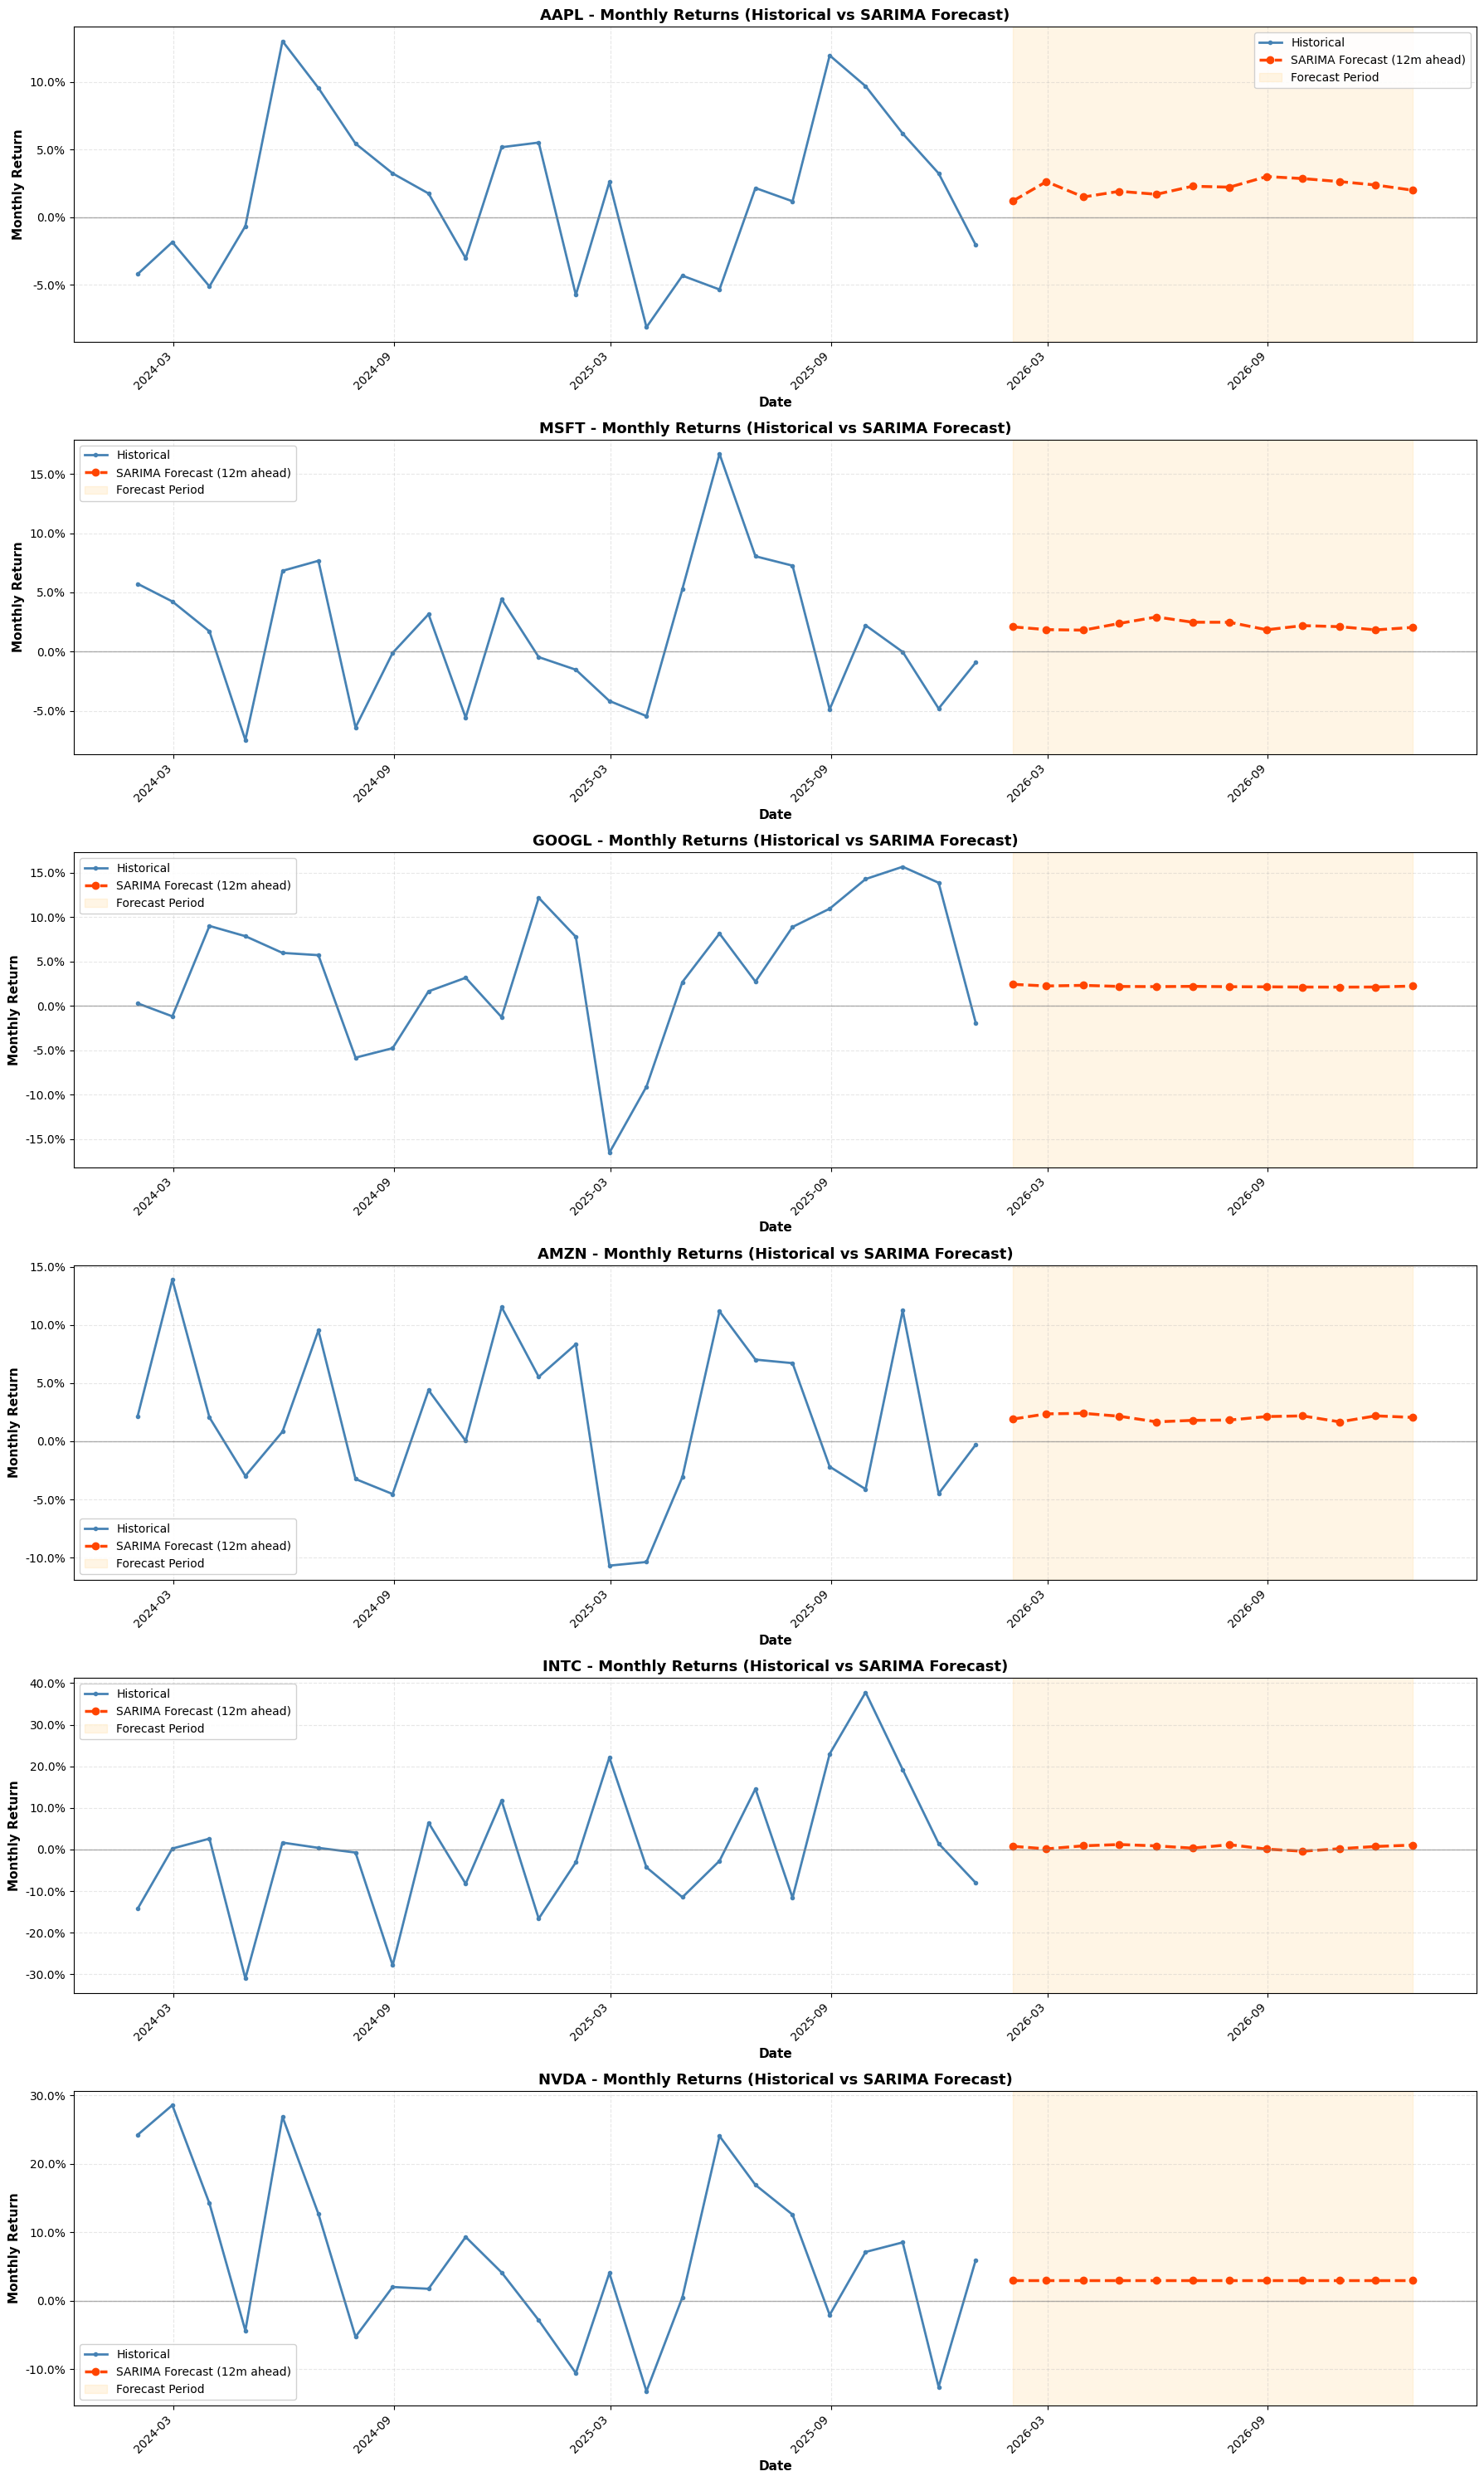


=== Summary Statistics: Historical vs Forecast ===


,Hist Mean (monthly),Hist Std (monthly),Forecast Mean (monthly),Forecast Std (monthly)
Ticker,,,,
AAPL,0.0245,0.0793,0.0219,0.0055
MSFT,0.0213,0.0591,0.0217,0.0034
GOOGL,0.0205,0.0722,0.0221,0.0009
AMZN,0.0211,0.0856,0.0202,0.0025
INTC,0.0088,0.1029,0.0058,0.0050
NVDA,0.0570,0.1368,0.0300,0.0000


In [77]:
## 3.1) Visualización: Historical vs SARIMA Forecast por ticker

def plot_sarima_forecasts(ret_m, forecast_paths, tickers, n_hist_months=36):
    """
    Plot historical monthly returns vs SARIMA forecast for each ticker.
    One plot per ticker (vertical layout) for better X-axis visibility.
    
    Parameters:
    -----------
    ret_m : pd.DataFrame
        Monthly returns dataframe
    forecast_paths : dict
        Dictionary with ticker -> forecast Series
    tickers : list
        List of tickers to plot
    n_hist_months : int
        Number of historical months to display
    """
    n_tickers = len(tickers)
    
    # One column layout (vertical stacking)
    fig, axes = plt.subplots(n_tickers, 1, figsize=(18, 5 * n_tickers))
    
    # Handle single ticker case
    if n_tickers == 1:
        axes = [axes]
    
    for i, ticker in enumerate(tickers):
        ax = axes[i]
        
        # Historical data (last n_hist_months)
        hist = ret_m[ticker].dropna().tail(n_hist_months)
        
        # Forecast
        fc = forecast_paths.get(ticker, pd.Series())
        
        # Plot historical
        ax.plot(hist.index, hist.values, 
                label='Historical', color='steelblue', linewidth=2, marker='.')
        
        # Plot forecast
        if len(fc) > 0:
            ax.plot(fc.index, fc.values, 
                    label='SARIMA Forecast (12m ahead)', color='orangered', 
                    linewidth=2.5, linestyle='--', marker='o', markersize=6)
            
            # Add shaded area for forecast region
            ax.axvspan(fc.index[0], fc.index[-1], alpha=0.1, color='orange', 
                      label='Forecast Period')
        
        # Add zero line
        ax.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.6)
        
        # Styling
        ax.set_title(f'{ticker} - Monthly Returns (Historical vs SARIMA Forecast)', 
                    fontweight='bold', fontsize=13)
        ax.set_xlabel('Date', fontweight='bold', fontsize=11)
        ax.set_ylabel('Monthly Return', fontweight='bold', fontsize=11)
        ax.legend(loc='best', fontsize=10, framealpha=0.9)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Format y-axis as percentage
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
        
        # Improve X-axis date formatting
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Every 6 months
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
    plt.tight_layout()
    plt.show()

# Generate plots
plot_sarima_forecasts(ret_m, forecast_paths, tickers, n_hist_months=24)  # Show last 24 months

# Optional: Summary statistics table
summary_stats = []
for ticker in tickers:
    hist_mean = ret_m[ticker].mean()
    hist_std = ret_m[ticker].std()
    fc = forecast_paths.get(ticker, pd.Series())
    fc_mean = fc.mean() if len(fc) > 0 else np.nan
    fc_std = fc.std() if len(fc) > 0 else np.nan
    
    summary_stats.append({
        'Ticker': ticker,
        'Hist Mean (monthly)': hist_mean,
        'Hist Std (monthly)': hist_std,
        'Forecast Mean (monthly)': fc_mean,
        'Forecast Std (monthly)': fc_std
    })

summary_df = pd.DataFrame(summary_stats).set_index('Ticker')
print("\n=== Summary Statistics: Historical vs Forecast ===")
display(summary_df.round(4))

In [78]:
for i, ticker in enumerate(tickers):
    if ticker=="AAPL":
        hist = ret_m[ticker].dropna().tail(48)
        print(hist)


Date
2022-01-31   -0.015712
2022-02-28   -0.054066
2022-03-31    0.057474
2022-04-30   -0.097131
2022-05-31   -0.054496
2022-06-30   -0.081430
2022-07-31    0.188634
2022-08-31   -0.031208
2022-09-30   -0.120977
2022-10-31    0.109551
2022-11-30   -0.033027
2022-12-31   -0.122273
2023-01-31    0.110521
2023-02-28    0.023183
2023-03-31    0.118648
2023-04-30    0.028987
2023-05-31    0.046058
2023-06-30    0.094330
2023-07-31    0.012786
2023-08-31   -0.042384
2023-09-30   -0.088678
2023-10-31   -0.002570
2023-11-30    0.113780
2023-12-31    0.013583
2024-01-31   -0.042227
2024-02-29   -0.018543
2024-03-31   -0.051287
2024-04-30   -0.006706
2024-05-31    0.130222
2024-06-30    0.095553
2024-07-31    0.054411
2024-08-31    0.032354
2024-09-30    0.017467
2024-10-31   -0.030429
2024-11-30    0.051707
2024-12-31    0.055155
2025-01-31   -0.057583
2025-02-28    0.025872
2025-03-31   -0.081500
2025-04-30   -0.043353
2025-05-31   -0.053584
2025-06-30    0.021509
2025-07-31    0.011698
2025-0

## 4) Compute historical expected return (μ_hist) and blend (μ_final)

In [79]:
# Historical expected return for 1-year horizon from monthly returns
mu_hist = ((1 + ret_m[tickers].mean())**12 - 1)

# Blend for robustness
mu_final = (1 - alpha) * mu_hist + alpha * mu_arima.reindex(mu_hist.index)

pd.DataFrame({
    "mu_hist_1y": mu_hist,
    "mu_arima_1y": mu_arima,
    "mu_final_1y": mu_final
}).sort_values("mu_final_1y", ascending=False)


,mu_hist_1y,mu_arima_1y,mu_final_1y
NVDA,0.944108,0.425761,0.736769
AAPL,0.336827,0.296107,0.320539
MSFT,0.288095,0.293810,0.290381
GOOGL,0.276212,0.299481,0.285520
AMZN,0.284900,0.271712,0.279625
INTC,0.110703,0.071424,0.094991


## 5) Estimate annual covariance (Σ) from monthly returns

In [80]:
# Covariance estimated from portfolio tickers only
cov_m = ret_m[tickers].cov()
cov_ann = 12 * cov_m  # annualize

cov_ann.iloc[:5, :5]


Ticker,AAPL,MSFT,GOOGL,AMZN,INTC
Ticker,,,,,
AAPL,0.075400,0.032067,0.033153,0.042606,0.036313
MSFT,0.032067,0.041844,0.029864,0.038942,0.025537
GOOGL,0.033153,0.029864,0.062597,0.042564,0.027965
AMZN,0.042606,0.038942,0.042564,0.087925,0.023800
INTC,0.036313,0.025537,0.027965,0.023800,0.126985


## 6) MV Optimization: maximize Sharpe with rf under constraints

In [81]:
def portfolio_return(w, mu):
    return float(np.dot(w, mu))

def portfolio_vol(w, cov):
    return float(np.sqrt(np.dot(w, np.dot(cov, w))))

def neg_sharpe(w, mu, cov, rf):
    vol = portfolio_vol(w, cov)
    if vol <= 1e-12:
        return 1e6
    excess = portfolio_return(w, mu) - rf
    return -excess / vol

def solve_mvo_sharpe(mu, cov, rf=0.04, max_vol=0.225, wmin=0.01, wmax=0.25):
    tickers = mu.index.tolist()
    n = len(tickers)

    w0 = np.ones(n) / n
    w0 = np.clip(w0, wmin, wmax)
    w0 = w0 / w0.sum()

    bounds = [(wmin, wmax) for _ in range(n)]
    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1.0},
        {"type": "ineq", "fun": lambda w: max_vol - portfolio_vol(w, cov.values)}
    ]

    res = minimize(
        fun=lambda w: neg_sharpe(w, mu.values, cov.values, rf),
        x0=w0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"maxiter": 2000, "ftol": 1e-9, "disp": False}
    )
    if not res.success:
        raise RuntimeError(f"Optimization failed: {res.message}")

    return pd.Series(res.x, index=tickers), res

w_opt, opt_res = solve_mvo_sharpe(
    mu=mu_final,
    cov=cov_ann,
    rf=risk_free_rate,
    max_vol=max_volatility,
    wmin=min_weight,
    wmax=max_weight
)

w_opt.sort_values(ascending=False)


MSFT     0.300000
GOOGL    0.249155
AAPL     0.178226
NVDA     0.172619
AMZN     0.050000
INTC     0.050000
dtype: float64

## 7) Report: recommended weights + portfolio metrics

In [82]:
ret_opt = portfolio_return(w_opt.values, mu_final.values)
vol_opt = portfolio_vol(w_opt.values, cov_ann.values)
sharpe_opt = (ret_opt - risk_free_rate) / vol_opt if vol_opt > 0 else np.nan

report = pd.DataFrame({
    "weight_recommended": w_opt,
    "mu_final_1y": mu_final,
    "mu_hist_1y": mu_hist,
    "mu_arima_1y": mu_arima
}).sort_values("weight_recommended", ascending=False)

print("=== Recommended Portfolio (MVP) ===")
print(f"Expected return (1y): {ret_opt:.2%}")
print(f"Expected vol (ann):   {vol_opt:.2%}   (max allowed {max_volatility:.2%})")
print(f"Sharpe (rf={risk_free_rate:.2%}): {sharpe_opt:.3f}")

report


=== Recommended Portfolio (MVP) ===
Expected return (1y): 36.13%
Expected vol (ann):   22.50%   (max allowed 22.50%)
Sharpe (rf=4.00%): 1.428


,weight_recommended,mu_final_1y,mu_hist_1y,mu_arima_1y
MSFT,0.300000,0.290381,0.288095,0.293810
GOOGL,0.249155,0.285520,0.276212,0.299481
AAPL,0.178226,0.320539,0.336827,0.296107
NVDA,0.172619,0.736769,0.944108,0.425761
AMZN,0.050000,0.279625,0.284900,0.271712
INTC,0.050000,0.094991,0.110703,0.071424


## 8) Compare performance over time: Original vs Recommended (static weights)
We compute the cumulative growth of $1 invested in each portfolio using **daily** prices and **static weights** (no rebalancing within the period).

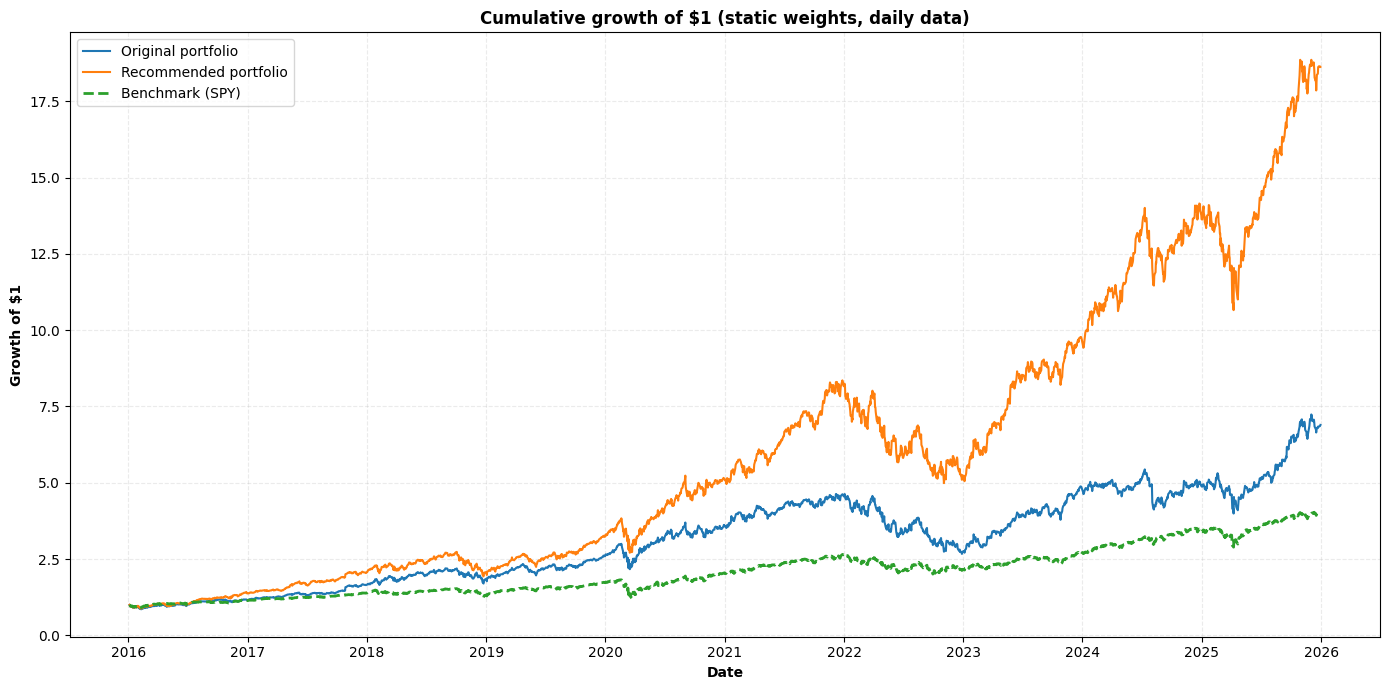

,final_growth_$1
Original,6.894018
Recommended,18.624460
Benchmark (SPY),4.032407


In [83]:
import matplotlib.pyplot as plt

def portfolio_cumulative_value(prices_daily, weights):
    # Align columns and weights
    w = weights.reindex(prices_daily.columns).fillna(0.0).astype(float)
    w = w / w.sum()
    # Daily returns
    r = prices_daily.pct_change().dropna()
    # Portfolio daily return
    pr = (r * w.values).sum(axis=1)
    # Growth of $1
    return (1 + pr).cumprod()

# Daily prices for portfolio tickers (drop benchmark if present)
prices_port_d = prices_d[tickers].dropna(how="all")

# Original and recommended weights (aligned & normalized)
w_current = current_weights.reindex(tickers).fillna(0.0)
w_current = w_current / w_current.sum()

w_reco = w_opt.reindex(tickers).fillna(0.0)
w_reco = w_reco / w_reco.sum()

cum_current = portfolio_cumulative_value(prices_port_d, w_current)
cum_reco = portfolio_cumulative_value(prices_port_d, w_reco)

# Optional benchmark series (growth of $1)
cum_bm = None
if benchmark is not None and benchmark in prices_d.columns:
    bm_prices = prices_d[[benchmark]].dropna()
    bm_ret = bm_prices.pct_change().dropna()
    cum_bm = (1 + bm_ret[benchmark]).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(cum_current.index, cum_current.values, label="Original portfolio")
plt.plot(cum_reco.index, cum_reco.values, label="Recommended portfolio")
if cum_bm is not None:
    plt.plot(cum_bm.index, cum_bm.values, label=f"Benchmark ({benchmark})", linestyle="--", linewidth=2)

plt.title("Cumulative growth of $1 (static weights, daily data)", fontweight="bold")
plt.xlabel("Date", fontweight="bold")
plt.ylabel("Growth of $1", fontweight="bold")
plt.grid(True, alpha=0.25, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

# Summary
final_table = pd.DataFrame({
    "final_growth_$1": {
        "Original": float(cum_current.iloc[-1]),
        "Recommended": float(cum_reco.iloc[-1]),
        **({f"Benchmark ({benchmark})": float(cum_bm.iloc[-1])} if cum_bm is not None else {})
    }
})
final_table


## 9) Optional: Compare against current weights (weights table)


In [84]:
# Current weights are computed from `portfolio` at the top.
cw = current_weights.reindex(w_opt.index).fillna(0.0).astype(float)
if cw.sum() > 0:
    cw = cw / cw.sum()

delta = w_opt - cw
comp = pd.DataFrame({
    "weight_current": cw,
    "weight_recommended": w_opt,
    "delta": delta
}).sort_values("delta", ascending=False)

comp


,weight_current,weight_recommended,delta
NVDA,0.008772,0.172619,0.163847
MSFT,0.175439,0.300000,0.124561
GOOGL,0.157895,0.249155,0.091260
AAPL,0.131579,0.178226,0.046647
AMZN,0.263158,0.050000,-0.213158
INTC,0.263158,0.050000,-0.213158


In [ ]:

print("\n" + "="*60)
print("RESUMEN FINAL - COMPARACIÓN VÁLIDA")
print("="*60)

# Solo comparar Original vs SPY (ambos son válidos)
valid_comparison = pd.DataFrame({
    'Initial Investment': ['$1.00', '$1.00'],
    'Final Value (2025)': [f'${cum_current.iloc[-1]:.2f}', f'${cum_bm.iloc[-1]:.2f}'],
    'Total Return': [f'{(cum_current.iloc[-1]-1)*100:.1f}%', f'{(cum_bm.iloc[-1]-1)*100:.1f}%'],
    'CAGR (10y)': [
        f'{((cum_current.iloc[-1]**(1/10))-1)*100:.2f}%',
        f'{((cum_bm.iloc[-1]**(1/10))-1)*100:.2f}%'
    ]
}, index=['Original Portfolio', 'SPY Benchmark'])

print(valid_comparison.to_string())

print(f"\n{'='*60}")
print("⚠️  NOTA IMPORTANTE:")
print("El portafolio 'Recommended' (18.62x) NO está incluido porque")
print("usa información futura (SARIMA forecast) aplicada al pasado.")
print(f"{'='*60}\n")

# Mostrar composición del portafolio original
print("\n=== Composición del Portafolio Original ===")
original_composition = pd.DataFrame({
    'Ticker': tickers,
    'Weight': [current_weights[t] for t in tickers],
    'Growth (2016-2025)': [
        prices_port_d[t].dropna().iloc[-1] / prices_port_d[t].dropna().iloc[0] 
        for t in tickers
    ],
    'Contribution': [
        current_weights[t] * (prices_port_d[t].dropna().iloc[-1] / prices_port_d[t].dropna().iloc[0])
        for t in tickers
    ]
}).sort_values('Contribution', ascending=False)

print(original_composition.to_string(index=False))
print(f"\nTotal Portfolio Growth: {original_composition['Contribution'].sum():.2f}x")
print(f"Actual Cumulative Growth: {cum_current.iloc[-1]:.2f}x")
print("(Diferencia por efectos de timing y correlación)")


RESUMEN FINAL - COMPARACIÓN VÁLIDA
                   Initial Investment Final Value (2025) Total Return CAGR (10y)
Original Portfolio              $1.00              $6.89       589.4%     21.30%
SPY Benchmark                   $1.00              $4.03       303.2%     14.96%

⚠️  NOTA IMPORTANTE:
El portafolio 'Recommended' (18.62x) NO está incluido porque
usa información futura (SARIMA forecast) aplicada al pasado.


=== Composición del Portafolio Original ===
Ticker   Weight  Growth (2016-2025)  Contribution
  NVDA 0.008772          237.516327      2.083477
  AMZN 0.263158            7.300899      1.921289
  MSFT 0.175439           10.159336      1.782340
  AAPL 0.131579           11.496578      1.512708
 GOOGL 0.157895            8.327751      1.314908
  INTC 0.263158            1.388538      0.365405

Total Portfolio Growth: 8.98x
Actual Cumulative Growth: 6.89x
(Diferencia por efectos de timing y correlación)
